<a href="https://colab.research.google.com/github/meetraj19/Agents/blob/main/enhanced_learning_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install langchain-community langchain-openai langgraph pydantic python-dotenv semantic-chunkers semantic-router tavily-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.6/249.6 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing insta

In [98]:
import os
import operator
import uuid
from typing import Annotated, Dict, List, Optional, Tuple, TypedDict

from IPython.display import Image, display
from langchain_community.utils.math import cosine_similarity
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from semantic_chunkers import StatisticalChunker
from semantic_router.encoders import OpenAIEncoder

In [100]:
import os
from google.colab import userdata

# Get API key from userdata (or replace with your actual key if needed)
tavily_api_key = userdata.get('TAVILY_API_KEY')

# Set as environment variable
os.environ['TAVILY_API_KEY'] = tavily_api_key

# Now initialize TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [101]:
openai_api_key = userdata.get('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = openai_api_key
llm = ChatOpenAI(model="gpt-4o", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [102]:
class Goals(BaseModel):
  """Structure for defining learning goals"""
  goals: str = Field(None, description="Learning goals")

class LearningCheckpoint(BaseModel):
  """structure for a single checkpoint"""
  description: str = Field(..., description="Main checkpoint description")
  criteria: list[str] =  Field(..., description="List of criteria")
  verification: str = Field(..., description="how to verify this checkpoint")

class Checkpoints(BaseModel):
    """Main checkpoints container with index tracking"""
    checkpoints: List[LearningCheckpoint] = Field(
        ...,
        description="List of checkpoints covering foundation, application, and mastery levels"
    )

class SearchQuery(BaseModel):
    """Structure for search query collection"""
    search_queries: list = Field(None, description="Search queries for retrieval.")

class LearningVerification(BaseModel):
    """Structure for verification results"""
    understanding_level: float = Field(..., ge=0, le=1)
    feedback: str
    suggestions: List[str]
    context_alignment: bool

class FeynmanTeaching(BaseModel):
    """Structure for Feynman teaching method"""
    simplified_explanation: str
    key_concepts: List[str]
    analogies: List[str]

class QuestionOutput(BaseModel):
    """Structure for question generation output"""
    question: str

class InContext(BaseModel):
    """Structure for context verification"""
    is_in_context: str = Field(..., description="Yes or No")


In [103]:
class LearningState(TypedDict):
  topic: str
  Goals: List[Goals]
  context: str
  context_chunks : Annotated[list, operator.add]
  context_key : str
  search_queries: SearchQuery
  checkpoints: Checkpoints
  verifications: LearningVerification
  teachings: FeynmanTeaching
  currentCheckpoint: int
  current_question: QuestionOutput
  current_answer: str

In [104]:
def extract_content_from_chunks(chunks):
    """Extract and combine content from chunks with splits attribute.

    Args:
        chunks: List of chunk objects that may contain splits attribute

    Returns:
        str: Combined content from all chunks joined with newlines
    """
    content = []

    for chunk in chunks:
        if hasattr(chunk, 'splits') and chunk.splits:
            chunk_content = ' '.join(chunk.splits)
            content.append(chunk_content)

    return '\n'.join(content)

def format_checkpoints_as_message(checkpoints: Checkpoints) -> str:
    """Convert Checkpoints object to a formatted string for the message.

    Args:
        checkpoints (Checkpoints): Checkpoints object containing learning checkpoints

    Returns:
        str: Formatted string containing numbered checkpoints with descriptions and criteria
    """
    message = "Here are the learning checkpoints:\n\n"
    for i, checkpoint in enumerate(checkpoints.checkpoints, 1):
        message += f"Checkpoint {i}:\n"
        message += f"Description: {checkpoint.description}\n"
        message += "Success Criteria:\n"
        for criterion in checkpoint.criteria:
            message += f"- {criterion}\n"
    return message

def generate_checkpoint_message(checks: List[LearningCheckpoint]) -> HumanMessage:
    """Generate a formatted message for learning checkpoints that need context.

    Args:
        checks (List[LearningCheckpoint]): List of learning checkpoint objects

    Returns:
        HumanMessage: Formatted message containing checkpoint descriptions, criteria and
                     verification methods, ready for context search
    """
    formatted_checks = []

    for check in checks:
        checkpoint_text = f"""
        Description: {check.description}
        Success Criteria:
        {chr(10).join(f'- {criterion}' for criterion in check.criteria)}
        Verification Method: {check.verification}
        """
        formatted_checks.append(checkpoint_text)

    all_checks = "\n---\n".join(formatted_checks)

    checkpoints_message = HumanMessage(content=f"""The following learning checkpoints need additional context:
        {all_checks}

        Please generate search queries to find relevant information.""")

    return checkpoints_message

In [105]:
learning_checkpoints_generator = SystemMessage(content="""You will be given a learning topic title and learning objectives.
Your goal is to generate clear learning checkpoints that will help verify understanding and progress through the topic.
The output should be in the following dictionary structure:
checkpoint
-> description (level checkpoint description)
-> criteria
-> verification (How to verify this checkpoint (Feynman Methods))
Requirements for each checkpoint:
- Description should be clear and concise
- Criteria should be specific and measurable (3-5 items)
- Verification method should be practical and appropriate for the level
- Verification will be checked by language model, so it must by in natural language
- All elements should align with the learning objectives
- Use action verbs and clear language
Ensure all checkpoints progress logically from foundation to mastery.
IMPORTANT - ANSWER ONLY 3 CHECKPOINTS""")

checkpoint_based_query_generator = SystemMessage(content="""You will be given learning checkpoints for a topic.
Your goal is to generate search queries that will retrieve content matching each checkpoint's requirements from retrieval systems or web search.
Follow these steps:
1. Analyze each learning checkpoint carefully
2. For each checkpoint, generate ONE targeted search query that will retrieve:
   - Content for checkpoint verification""")

validate_context = SystemMessage(content="""You will be given a learning criteria and context.
Check if the the criteria could be answered using the context.
Always answer YES or NO""")

question_generator = SystemMessage(content="""You will be given a checkpoint description, success criteria, and verification method.
Your goal is to generate an appropriate question that aligns with the checkpoint's verification requirements.
The question should:
1. Follow the specified verification method
2. Cover all success criteria
3. Encourage demonstration of understanding
4. Be clear and specific
Output should be a single, well-formulated question that effectively tests the checkpoint's learning objectives.""")

answer_verifier = SystemMessage(content="""You will be given a student's answer, question, checkpoint details, and relevant context.
Your goal is to analyze the answer against the checkpoint criteria and provided context.
Analyze considering:
1. Alignment with verification method specified
2. Coverage of all success criteria
3. Use of relevant concepts from context
4. Depth and accuracy of understanding
Output should include:
- understanding_level: float between 0 and 1
- feedback: detailed explanation of the assessment
- suggestions: list of specific improvements
- context_alignment: boolean indicating if the answer aligns with provided context""")

feynman_teacher = SystemMessage(content="""You will be given verification results, checkpoint criteria, and learning context.
Your goal is to create a Feynman-style teaching explanation for concepts that need reinforcement.
The explanation should include:
1. Simplified explanation without technical jargon
2. Concrete, relatable analogies
3. Key concepts to remember
Output should follow the Feynman technique:
- simplified_explanation: clear, jargon-free explanation
- key_concepts: list of essential points
- analogies: list of relevant, concrete comparisons
Focus on making complex ideas accessible and memorable.""")

In [106]:
class ContextStore:
  def __init__(self):
    self.store = InMemoryStore()

  def save_context(self , context_chunks: list, embeddings: list, key: str = None):
    namespace = ("context")
    if key is None:
      key = str(uuid.uuid4())

    value = {
        "chunks": context_chunks,
        "embeddings": embeddings
    }
    self.store.save(namespace, key, value)
    return key

  def get_context(self, context_key: str):
    namespace = ("context")
    memory = self.store.get(namespace, context_key)
    return memory


In [117]:
from re import search
def generate_query(state: LearningState):
  """generates search queries based on learning checkpoints from current state"""
  structured_llm = llm.with_structured_output(SearchQuery)
  checkpoints_message = HumanMessage(content=format_checkpoints_as_message(state["checkpoints"]))
  messages = [checkpoint_based_query_generator, checkpoints_message]
  search_queries = structured_llm.invoke(messages)
  return {search_queries: search_queries}


def search_web(state: LearningState):
    all_search_docs = []
    for query in search_queries:
      search_docs = tavily_search.invoke(query)
      all_search_docs.extend(search_docs)

    formatted_search_docs = [
        f'context: {doc["context"]}\n Source: {doc["url"]}'
        for doc in all_search_docs
    ]
    chunk_embeddings = embeddings.embed_documents(formatted_search_docs)
    context_key = context_store.save_context(
        content,
        chunk_embeddings,
        key=state.get('context_key')
    )
    return {"context_chunks": formatted_search_docs}

def generate_checkpoints(state: LearningState):
  """generates learning checkpoints from current state"""
  structured_llm = llm.with_structured_output(Checkpoints)

  # Get 'goals' safely using get() with a default value
  goals = state.get('goals', [])

  messages = [
        learning_checkpoints_generator,
        SystemMessage(content=f"Topic: {state['topic']}"),
        SystemMessage(content=f"Goals: {','.join(str(goal) for goal in goals)}")  # Use goals variable here
    ]
  checkpoints = structured_llm.invoke(messages)

  # Include goals in the output to ensure it's passed along
  return {"checkpoints": checkpoints, "goals": goals}

def chunk_content(state: LearningState):
  """chunks content based on current state"""
  encoder = OpenAIEncoder(name = "text-embedding-3-large")
  chunker = StatisticalChunker(
      encoder=encoder,
      min_split_tokens=128,
      max_split_tokens=512
  )
  chunks = chunker([state['context']])
  content = []
  for chunk in chunks:
    content.append(extract_content_from_chunks)
  chunk_embeddings = embeddings.embed_documents(content)
  context_key = context_store.save_context(
      content,
      chunk_embeddings,
      key=state.get('context_key')
  )
  return {"context_chunks": content, "context_key": context_key}

def context_validation(state: LearningState):
    """Validates context coverage against checkpoint criteria using stored embeddings."""
    context = context_store.get_context(state['context_key'])
    chunks = context['chunks']
    chunk_embeddings = context['embeddings']

    checks = []
    structured_llm = llm.with_structured_output(InContext)

    for checkpoint in state['checkpoints'].checkpoints:
        query = embeddings.embed_query(checkpoint.verification)

        similarities = cosine_similarity([query], chunk_embeddings)[0]
        top_3_indices = sorted(range(len(similarities)),
                             key=lambda i: similarities[i],
                             reverse=True)[:3]
        relevant_chunks = [chunks[i] for i in top_3_indices]

        messages = [
            validate_context,
            HumanMessage(content=f"""
            Criteria:
            {chr(10).join(f"- {c}" for c in checkpoint.criteria)}

            Context:
            {chr(10).join(relevant_chunks)}
            """)
        ]

        response = structured_llm.invoke(messages)
        if response.is_in_context.lower() == "no":
            checks.append(checkpoint)

    if checks:
        structured_llm = llm.with_structured_output(SearchQuery)
        checkpoints_message = generate_checkpoint_message(checks)

        messages = [checkpoint_based_query_generator, checkpoints_message]
        search_queries = structured_llm.invoke(messages)
        return {"search_queries": search_queries}

    return {"search_queries": None}

def generate_question(state: LearningState):
    """Generates assessment questions based on current checkpoint verification requirements."""
    structured_llm = llm.with_structured_output(QuestionOutput)
    current_checkpoint = state['current_checkpoint']
    checkpoint_info = state['checkpoints'].checkpoints[current_checkpoint]

    messages = [
        question_generator,
        HumanMessage(content=f"""
        Checkpoint Description: {checkpoint_info.description}
        Success Criteria:
        {chr(10).join(f"- {c}" for c in checkpoint_info.criteria)}
        Verification Method: {checkpoint_info.verification}

        Generate an appropriate verification question.""")
    ]

    question_output = structured_llm.invoke(messages)
    return {"current_question": question_output.question}

def verify_answer(state: LearningState):
    """Evaluates user answers against checkpoint criteria using relevant context chunks."""
    structured_llm = llm.with_structured_output(LearningVerification)
    current_checkpoint = state['current_checkpoint']
    checkpoint_info = state['checkpoints'].checkpoints[current_checkpoint]

    context = context_store.get_context(state['context_key'])
    chunks = context['chunks']
    chunk_embeddings = context['embeddings']

    query = embeddings.embed_query(checkpoint_info.verification)

    similarities = cosine_similarity([query], chunk_embeddings)[0]
    top_3_indices = sorted(range(len(similarities)),
                         key=lambda i: similarities[i],
                         reverse=True)[:3]
    relevant_chunks = [chunks[i] for i in top_3_indices]

    messages = [
        answer_verifier,
        HumanMessage(content=f"""
        Question: {state['current_question']}
        Answer: {state['current_answer']}

        Checkpoint Description: {checkpoint_info.description}
        Success Criteria:
        {chr(10).join(f"- {c}" for c in checkpoint_info.criteria)}
        Verification Method: {checkpoint_info.verification}

        Context:
        {chr(10).join(relevant_chunks)}

        Assess the answer.""")
    ]

    verification = structured_llm.invoke(messages)
    return {"verifications": verification}

def teach_concept(state: LearningState):
    """Creates simplified Feynman-style explanations for concepts that need reinforcement."""
    structured_llm = llm.with_structured_output(FeynmanTeaching)
    current_checkpoint = state['current_checkpoint']
    checkpoint_info = state['checkpoints'].checkpoints[current_checkpoint]

    messages = [
        feynman_teacher,
        HumanMessage(content=f"""
        Criteria: {checkpoint_info.criteria}
        Verification: {state['verifications']}

        Context:
        {state['context_chunks']}

        Create a Feynman teaching explanation.""")
    ]

    teaching = structured_llm.invoke(messages)
    return {"teachings": teaching}


In [118]:
def user_answer(state: LearningState):
    """Placeholder for handling user's answer input."""
    pass

def next_checkpoint(state: LearningState):
    """Advances to the next checkpoint in the learning sequence."""
    current_checkpoint = state['current_checkpoint'] + 1
    return {'current_checkpoint': current_checkpoint}

In [119]:
def  route_context(state: LearningState):
  if state.get('context'):
    return 'chunk_content'
  return 'generate_query'

def route_verification(state: LearningState):

  current_checkpoint = state['current_checkpoint']

  if state['verifications'].understanding_level < 0.7:
    return 'teach_concept'

  if current_checkpoint + 1 < len(state['checkpoints'].checkpoints):
    return 'next_checkpoint'

  return END


def route_teaching(state: LearningState):
  current_checkpoint = state['current_checkpoint']

  if current_checkpoint + 1 < len(state['checkpoints'].checkpoints):
    return 'next_checkpoint'

  return END

def route_search(state: LearningState):
  if state.get('search_queries') is None:
    return 'generate_question'
  return 'search_web'

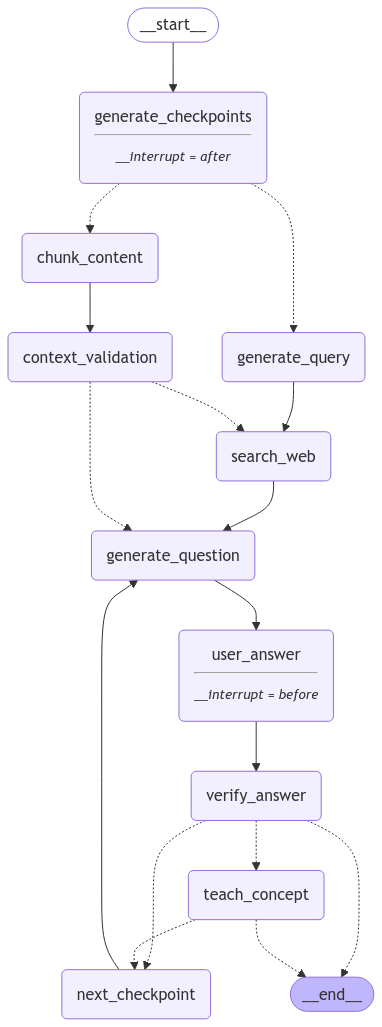

In [120]:
searcher = StateGraph(LearningState)
memory = InMemoryStore()
context_store = ContextStore()

searcher.add_node("generate_query", generate_query)
searcher.add_node("search_web", search_web)
searcher.add_node("chunk_content", chunk_content)
searcher.add_node("context_validation", context_validation)
searcher.add_node("generate_checkpoints", generate_checkpoints)
searcher.add_node("generate_question", generate_question)
searcher.add_node("next_checkpoint", next_checkpoint)
searcher.add_node("user_answer", user_answer)
searcher.add_node("verify_answer", verify_answer)
searcher.add_node("teach_concept", teach_concept)

#flow
searcher.add_edge(START, "generate_checkpoints")
searcher.add_conditional_edges('generate_checkpoints', route_context, ['chunk_content', 'generate_query'])
searcher.add_edge("generate_query", "search_web")
searcher.add_edge("search_web", "generate_question")
searcher.add_edge("chunk_content", "context_validation")
searcher.add_conditional_edges('context_validation', route_search, ['search_web','generate_question'])
searcher.add_edge("generate_question", "user_answer")
searcher.add_edge("user_answer", "verify_answer")
searcher.add_conditional_edges("verify_answer", route_verification,
                               {
                                   "next_checkpoint": "next_checkpoint",
                                   "teach_concept": "teach_concept",
                                   END: END
                               }
)
searcher.add_conditional_edges("teach_concept", route_teaching,
                               {
                                   "next_checkpoint": "next_checkpoint",
                                   END: END
                               }
)
searcher.add_edge("next_checkpoint", "generate_question")



graph = searcher.compile(interrupt_after=["generate_checkpoints"], interrupt_before=["user_answer"], checkpointer= None)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [121]:
def print_checkpoints(event):
    """Pretty print checkpoints information with improved visual formatting"""
    checkpoints = event.get('checkpoints', '')
    if checkpoints:
        print("\n" + "=" * 80)
        print("🎯 LEARNING CHECKPOINTS OVERVIEW".center(80))
        print("=" * 80 + "\n")

        for i, checkpoint in enumerate(checkpoints.checkpoints, 1):
            # Checkpoint header with number
            print(f"📍 CHECKPOINT #{i}".center(80))
            print("─" * 80 + "\n")

            # Description section with text wrapping
            print("📝 Description:")
            print("─" * 40)
            words = checkpoint.description.split()
            current_line = []
            current_length = 0

            for word in words:
                if current_length + len(word) + 1 <= 70:
                    current_line.append(word)
                    current_length += len(word) + 1
                else:
                    print(f"  {' '.join(current_line)}")
                    current_line = [word]
                    current_length = len(word)

            if current_line:
                print(f"  {' '.join(current_line)}")
            print()

            # Success Criteria section
            print("✅ Success Criteria:")
            print("─" * 40)
            for j, criterion in enumerate(checkpoint.criteria, 1):
                # Wrap each criterion text
                words = criterion.split()
                current_line = []
                current_length = 0
                first_line = True

                for word in words:
                    if current_length + len(word) + 1 <= 66:  # Shorter width to account for numbering
                        current_line.append(word)
                        current_length += len(word) + 1
                    else:
                        if first_line:
                            print(f"  {j}. {' '.join(current_line)}")
                            first_line = False
                        else:
                            print(f"     {' '.join(current_line)}")
                        current_line = [word]
                        current_length = len(word)

                if current_line:
                    if first_line:
                        print(f"  {j}. {' '.join(current_line)}")
                    else:
                        print(f"     {' '.join(current_line)}")
            print()

            # Verification Method section
            print("🔍 Verification Method:")
            print("─" * 40)
            words = checkpoint.verification.split()
            current_line = []
            current_length = 0

            for word in words:
                if current_length + len(word) + 1 <= 70:
                    current_line.append(word)
                    current_length += len(word) + 1
                else:
                    print(f"  {' '.join(current_line)}")
                    current_line = [word]
                    current_length = len(word)

            if current_line:
                print(f"  {' '.join(current_line)}")
            print()

            # Separator between checkpoints
            if i < len(checkpoints.checkpoints):
                print("~" * 80 + "\n")

        print("=" * 80 + "\n")

def print_verification_results(event):
    """Pretty print verification results with improved formatting"""
    verifications = event.get('verifications', '')
    if verifications:
        print("\n" + "=" * 50)
        print("📊 VERIFICATION RESULTS".center(50))
        print("=" * 50 + "\n")

        # Understanding Level with visual bar
        understanding = verifications.understanding_level
        bar_length = 20
        filled_length = int(understanding * bar_length)
        bar = "█" * filled_length + "░" * (bar_length - filled_length)

        print(f"📈 Understanding Level: [{bar}] {understanding * 100:.1f}%\n")

        # Feedback section
        print("💡 Feedback:")
        print(f"{verifications.feedback}\n")

        # Suggestions section
        print("🎯 Suggestions:")
        for i, suggestion in enumerate(verifications.suggestions, 1):
            print(f"  {i}. {suggestion}")
        print()

        # Context Alignment
        print("🔍 Context Alignment:")
        print(f"{verifications.context_alignment}\n")

        print("-" * 50 + "\n")
def print_teaching_results(event):
    """Pretty print Feynman teaching results with improved formatting"""
    teachings = event.get('teachings', '')
    if teachings:
        print("\n" + "=" * 70)
        print("🎓 FEYNMAN TEACHING EXPLANATION".center(70))
        print("=" * 70 + "\n")

        # Simplified Explanation section
        print("📚 SIMPLIFIED EXPLANATION:")
        print("─" * 30)
        # Split explanation into paragraphs for better readability
        paragraphs = teachings.simplified_explanation.split('\n')
        for paragraph in paragraphs:
            # Wrap text at 60 characters for better readability
            words = paragraph.split()
            lines = []
            current_line = []
            current_length = 0

            for word in words:
                if current_length + len(word) + 1 <= 60:
                    current_line.append(word)
                    current_length += len(word) + 1
                else:
                    lines.append(' '.join(current_line))
                    current_line = [word]
                    current_length = len(word)

            if current_line:
                lines.append(' '.join(current_line))

            for line in lines:
                print(f"{line}")
            print()

        # Key Concepts section
        print("💡 KEY CONCEPTS:")
        print("─" * 30)
        for i, concept in enumerate(teachings.key_concepts, 1):
            print(f"  {i}. {concept}")
        print()

        # Analogies section
        print("🔄 ANALOGIES & EXAMPLES:")
        print("─" * 30)
        for i, analogy in enumerate(teachings.analogies, 1):
            print(f"  {i}. {analogy}")
        print()

        print("=" * 70 + "\n")

In [112]:
note = """Anemia: A Comprehensive Overview
Definition
Anemia is a medical condition characterized by a decrease in the total number of red blood cells (RBCs) or hemoglobin in the blood. This reduction leads to a diminished ability to carry oxygen to the body's tissues, affecting overall body function and health.
Blood Components and Their Role
Red blood cells, also known as erythrocytes, are fundamental components of blood that carry oxygen throughout the body. These cells contain hemoglobin, an iron-containing protein that gives blood its characteristic red color and is responsible for oxygen transport. The typical lifespan of a red blood cell is approximately 120 days, after which it must be replaced by new cells produced in the bone marrow.
Types of Anemia
Iron Deficiency Anemia represents the most prevalent form of anemia worldwide. It occurs due to insufficient iron intake or absorption, particularly affecting pregnant women, growing children, menstruating women, and individuals with poor nutritional intake.
Vitamin Deficiency Anemia develops when the body lacks sufficient amounts of vitamin B12 or folate (vitamin B9). This deficiency can stem from dietary inadequacies or problems with nutrient absorption in the digestive system.
Aplastic Anemia, though rare, presents a serious condition where the bone marrow fails to produce adequate blood cells. This form can be either inherited through genetic factors or acquired through various environmental causes or medical conditions.
Hemolytic Anemia occurs when red blood cells are destroyed at a rate faster than the body can replace them. This condition may be inherited through genetic factors or acquired through various external causes.
Clinical Manifestations
Anemia manifests through various symptoms including persistent fatigue and weakness. Patients often present with pale or yellowish skin, experience shortness of breath, and may suffer from dizziness. Additional symptoms include irregular heartbeat patterns, frequent headaches, cold extremities, and occasional chest pain.
Diagnostic Approach
Diagnosis begins with a thorough physical examination by a healthcare provider. Blood tests form the cornerstone of diagnosis, including a Complete Blood Count (CBC), assessment of iron levels, vitamin B12 measurement, and folate level determination. These tests help identify the specific type of anemia and guide appropriate treatment.
Treatment Strategies
Dietary modification serves as a fundamental treatment approach. This involves increasing consumption of iron-rich foods such as red meat, dark leafy vegetables, legumes, and iron-fortified cereals.
Supplementation often proves necessary and may include iron supplements, vitamin B12, or folic acid, depending on the underlying cause of anemia.
Medical interventions become necessary in severe cases. Blood transfusions may be required for severe anemia, while bone marrow transplantation might be considered for cases of aplastic anemia.
Preventive Measures
Prevention centers on maintaining a balanced diet rich in essential nutrients, particularly iron, vitamin B12, folate, and vitamin C, which enhances iron absorption. Regular medical check-ups allow for early detection and intervention.
Certain populations require special attention regarding prevention. These include pregnant women, menstruating women, growing children, individuals following vegetarian or vegan diets, and athletes who may have increased nutritional demands.
Potential Complications
Untreated anemia can lead to several serious complications. These include severe fatigue that impacts daily activities, complications during pregnancy, cardiovascular problems, depression, and cognitive difficulties that may affect work or school performance.
Clinical Significance
Anemia often serves as an indicator of other underlying medical conditions. Therefore, early detection and appropriate treatment prove crucial for optimal outcomes. Different forms of anemia require specific treatment approaches, and regular monitoring may be necessary to ensure treatment effectiveness."""

In [122]:
initial_input = {
    'topic': "Anemia",
    'goals': ['I am a medical student, i want to master the diagnosis of Anemia'],
    'context': note,
    'current_checkpoint': 0
}

In [123]:
thread = {"configurable": {"thread_id": "10"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    print_checkpoints(event)


                        🎯 LEARNING CHECKPOINTS OVERVIEW                         

                                📍 CHECKPOINT #1                                 
────────────────────────────────────────────────────────────────────────────────

📝 Description:
────────────────────────────────────────
  Understand the basic concepts of anemia, including its definition,
  causes, and types.

✅ Success Criteria:
────────────────────────────────────────
  1. Define anemia and its general symptoms.
  2. List at least three common causes of anemia.
  3. Identify and describe three different types of anemia.

🔍 Verification Method:
────────────────────────────────────────
  Explain anemia to a peer, including its definition, common causes,
  and types, using simple language. The peer should be able to summarize
  the explanation accurately.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                                📍 CHECKPOINT #2                        

In [124]:
from typing import List
import ipywidgets as widgets
from IPython.display import display
from pydantic import BaseModel

def create_checkpoint_editor(checkpoints_model: Checkpoints):
    """
    Creates an interactive checkpoint editor using a Pydantic model.

    Args:
        checkpoints_model: Pydantic model of Checkpoints class
    """
    # Convert to list of dictionaries for easier editing
    checkpoints = [cp.model_dump() for cp in checkpoints_model.checkpoints]
    checkpoints_widgets = []
    accepted_checkpoints = []

    def create_criterion_widget(checkpoint_index: int, criterion_value: str = "", criterion_index: int = None):
        """Creates a widget for a single criterion with a delete button"""
        criterion_container = widgets.HBox([
            widgets.Text(
                value=criterion_value,
                description=f'{criterion_index + 1}.' if criterion_index is not None else 'New',
                layout=widgets.Layout(width='85%')
            ),
            widgets.Button(
                description='Delete',
                button_style='danger',
                layout=widgets.Layout(width='15%')
            )
        ])

        def on_criterion_change(change):
            nonlocal criterion_index
            if criterion_index is not None:
                checkpoints[checkpoint_index]['criteria'][criterion_index] = change['new']

        def remove_criterion(b):
            if criterion_index is not None:
                checkpoints[checkpoint_index]['criteria'].pop(criterion_index)
                update_checkpoint_widget(checkpoint_index)

        criterion_container.children[0].observe(on_criterion_change, names='value')
        criterion_container.children[1].on_click(remove_criterion)

        return criterion_container

    def create_checkpoint_widget(checkpoint: dict, index: int):
        """Creates a widget for a single checkpoint"""

        def on_accept_change(change):
            if change['new']:
                accepted_checkpoints.append(index)
            else:
                if index in accepted_checkpoints:
                    accepted_checkpoints.remove(index)

        def on_description_change(change):
            checkpoints[index]['description'] = change['new']

        def on_verification_change(change):
            checkpoints[index]['verification'] = change['new']

        def add_criterion(b):
            checkpoints[index]['criteria'].append("")
            update_checkpoint_widget(index)

        def remove_checkpoint(b):
            checkpoints.pop(index)
            update_all_checkpoints()

        # Header with checkbox and delete button
        header = widgets.HBox([
            widgets.HTML(f'<h3 style="margin: 0;">Checkpoint {index + 1}</h3>'),
            widgets.Checkbox(
                value=False,
                description='Accept',
                indent=False,
                layout=widgets.Layout(margin='5px 0 0 20px')
            ),
            widgets.Button(
                description='Delete checkpoint',
                button_style='danger',
                layout=widgets.Layout(margin='0 0 0 20px')
            )
        ])

        # Description
        description = widgets.Textarea(
            value=checkpoint['description'],
            description='Description:',
            layout=widgets.Layout(width='95%', height='60px')
        )

        # Criteria
        criteria_label = widgets.HTML('<b>Criteria:</b>')
        criteria_container = widgets.VBox([
            create_criterion_widget(index, criterion, i)
            for i, criterion in enumerate(checkpoint['criteria'])
        ])

        # Add criterion button
        add_criterion_btn = widgets.Button(
            description='Add criterion',
            button_style='success',
            layout=widgets.Layout(margin='10px 0')
        )

        # Verification
        verification = widgets.Textarea(
            value=checkpoint['verification'],
            description='Verification:',
            layout=widgets.Layout(width='95%', height='60px', margin='10px 0')
        )

        separator = widgets.HTML('<hr style="margin: 20px 0;">')

        # Combine all elements
        checkpoint_widget = widgets.VBox([
            header,
            description,
            criteria_label,
            criteria_container,
            add_criterion_btn,
            verification,
            separator
        ])

        # Add observers and handlers
        header.children[1].observe(on_accept_change, names='value')
        header.children[2].on_click(remove_checkpoint)
        description.observe(on_description_change, names='value')
        verification.observe(on_verification_change, names='value')
        add_criterion_btn.on_click(add_criterion)

        return checkpoint_widget

    def update_checkpoint_widget(index: int):
        """Updates a single checkpoint widget"""
        if 0 <= index < len(checkpoints):
            checkpoints_widgets[index] = create_checkpoint_widget(checkpoints[index], index)
            update_main_container()

    def update_all_checkpoints():
        """Updates all checkpoint widgets"""
        nonlocal checkpoints_widgets
        checkpoints_widgets = [
            create_checkpoint_widget(checkpoint, i)
            for i, checkpoint in enumerate(checkpoints)
        ]
        update_main_container()

    def add_new_checkpoint(b):
        """Adds a new checkpoint"""
        checkpoints.append({
            'description': '',
            'criteria': [],
            'verification': ''
        })
        update_all_checkpoints()

    def get_pydantic_model() -> Checkpoints:
        """Converts the current editor state back to a Pydantic model"""
        return Checkpoints(checkpoints=[
            LearningCheckpoint(**checkpoint)
            for checkpoint in checkpoints
        ])

    # Create initial checkpoint widgets
    checkpoints_widgets = [
        create_checkpoint_widget(checkpoint, i)
        for i, checkpoint in enumerate(checkpoints)
    ]

    # Add new checkpoint button
    add_checkpoint_btn = widgets.Button(
        description='Add checkpoint',
        button_style='success',
        layout=widgets.Layout(margin='20px 0')
    )
    add_checkpoint_btn.on_click(add_new_checkpoint)

    # Main container
    main_container = widgets.VBox(
        checkpoints_widgets + [add_checkpoint_btn],
        layout=widgets.Layout(
            padding='20px',
            border='1px solid #ddd',
            border_radius='5px'
        )
    )

    def update_main_container():
        """Updates the main container"""
        main_container.children = tuple(checkpoints_widgets + [add_checkpoint_btn])

    # Add method to container to retrieve data later
    main_container.get_model = get_pydantic_model

    return main_container

In [125]:
checkpoints = event['checkpoints']

In [126]:
editor = create_checkpoint_editor(checkpoints)
display(editor)